In [ ]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.signal as sps
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import xscale
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import cut_regrid_reynolds_sst,cut_process_sst_obs_trends,proc_landschutzer,process_co2_land_trends
from C60_helper_functions import lin_wrapper


from C60_helper_functions import solubility
from C60_helper_functions import convert_CAFEatm_CO2times
import PyCO2SYS as pyco2

In [ ]:
# Coefs / Inputs
depth_integration=100
lat=0
lon=270
ens=26
startyear=2000
endyear=2017

regrid_fratios=False
process_interim=False
process_trends=False

# Could do caco3 as well ...

In [ ]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=16)
#cluster.adapt(minimum=2, maximum=16)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.143:38303,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.143:38303,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20))
eqpac['time']=eqpac.time.astype('datetime64[M]')
#eqpac.time
eqpac

,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,214.49 GiB,18.30 MiB
Shape,"(720, 96, 50, 98, 170)","(1, 96, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# Load atmospheric PCO2 and calculate delta pCO2.
# Input files have been copied from:
# cd /scratch/v14/rxm599/enkf-bgc5/MOM/INPUT/
# cp co2_obs.nc /g/data/xv83/np1383/processed_data/co2_obs.nc
# cp bgc_param.nc /g/data/xv83/np1383/processed_data/bgc_params.nc

atm_co2=xr.open_dataset('../processed_data/co2_obs.nc',decode_times=False) #../co2_obs.nc # '/scratch/v14/rxm599/enkf-bgc5/MOM/INPUT/co2_obs.nc'
bgc_params=xr.open_dataset('../processed_data/bgc_params.nc',decode_times=False) #../co2_obs.nc # '/scratch/v14/rxm599/enkf-bgc5/MOM/INPUT/bgc_params.nc'

atm_co2=convert_CAFEatm_CO2times(atm_co2)
atm_co2=atm_co2.rename({'grid_x_T':'lon','grid_y_T':'lat'})
atm_co2['lon']=atm_co2['lon']+360
atm_co2_eq=atm_co2.sel(lon=slice(120,290),lat=slice(-20,20))
atm_co2_eq['lat']=eqpac.lat # Overwrite test

dpco2=eqpac.pco2.sel(ensemble=26).sel(time=slice('1960-01-01','2017-01-01'))-atm_co2_eq.co2.sel(time=slice('1960-01-01','2017-01-01')).load()
eqpac['dpco2']=dpco2 #Sea minus Air
eqpac=eqpac.sel(ensemble=26)

In [7]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-20,20))
phys_eqpac
phys_eqpac=phys_eqpac.sel(ensemble=26)

In [8]:
phys_eqpac

,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,36721 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,36721 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [9]:
eqpac

,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,36721 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,36721 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [10]:
#detrended=xscale.signal.fitting.detrend(eqpac,dim='time')

In [ ]:
def detrend(da):
    return xr.apply_ufunc(
            sps.detrend,
            da.fillna(0),
            1,
            output_dtypes=[da.dtype],
            dask="parallelized")

def deseasonalise(da,keep_relative=True):
    deseasonalised= da.groupby("time.month") - da.groupby("time.month").mean("time")
    seasonality=(da-deseasonalised)
    base_seasonality=seasonality-seasonality.mean(dim='time')
    detrended_season_removed=da-base_seasonality
    if keep_relative==True:
        return detrended_season_removed
    else:
        return deseasonalised

In [54]:
eqpac.stf10.chunk({'time':-1}).to_netcdf('datasets/co2_flux_predetrend_temp.nc')

In [52]:
co2=xr.open_dataset('datasets/co2_flux_predetrend_temp.nc').stf10

In [53]:
#co2
co2_detrended=detrend(co2)
co2_deseasonalised=deseasonalise(co2_detrended)

In [53]:
seasonality=(np_detrended-np_deseasonalised)
base_seasonality=seasonality-seasonality.mean(dim='time')
np_2deseasonalise=np_detrended-base_seasonality

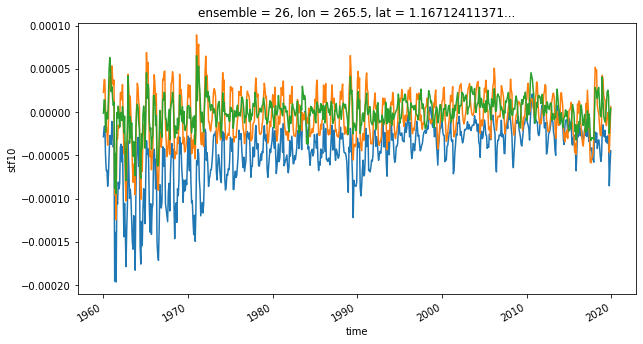

In [64]:
#co2
co2_detrended=detrend(co2)
co2_deseasonalised=deseasonalise(co2_detrended)

plt.figure(figsize=(10,5))
co2.sel(lat=1,lon=265,method='nearest').plot()
co2_detrended.sel(lat=1,lon=265,method='nearest').plot()
co2_deseasonalised.sel(lat=1,lon=265,method='nearest').plot()

In [56]:
eqpac.pprod_gross_2d.chunk({'time':-1}).to_netcdf('datasets/pprod_predetrend_temp.nc')

In [61]:
pprod=xr.open_dataset('datasets/pprod_predetrend_temp.nc').pprod_gross_2d

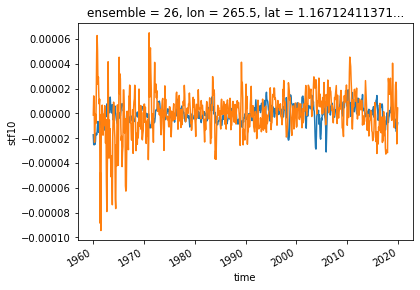

In [72]:
np_deseasonalised.sel(lat=1,lon=265,method='nearest').plot()
co2_deseasonalised.sel(lat=1,lon=265,method='nearest').plot()

In [66]:
np=pprod#eqpac.pprod_gross_2d
#co2
np_detrended=detrend(np)
np_deseasonalised=deseasonalise(np_detrended)

In [67]:
seasonality=(np_detrended-np_deseasonalised)
base_seasonality=seasonality-seasonality.mean(dim='time')
np_2deseasonalise=np_detrended-base_seasonality

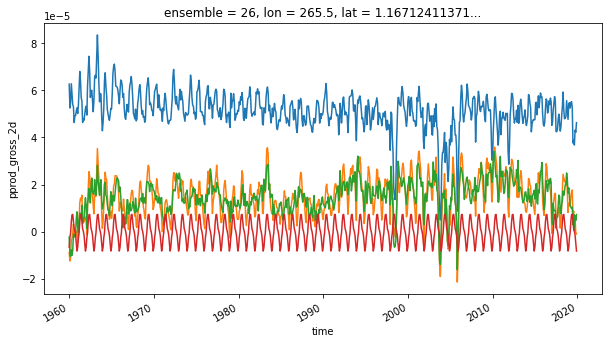

In [71]:
plt.figure(figsize=(10,5))
np.sel(lat=1,lon=265,method='nearest').plot()
np_detrended.sel(lat=1,lon=265,method='nearest').plot()
#np_deseasonalised.sel(lat=1,lon=265,method='nearest').plot()
#(np_detrended-np_deseasonalised).sel(lat=1,lon=265,method='nearest').plot()
np_2deseasonalise.sel(lat=1,lon=265,method='nearest').plot()
base_seasonality.sel(lat=1,lon=265,method='nearest').plot()

In [16]:
# Does detrend need to remove the mean, or can you somehow keep the relative magnitude? Surely.
# Same as seasonal decomposition. 


In [16]:
detrended_co2 = xr.apply_ufunc(
            sps.detrend,
            co2.fillna(0),
            1,
            output_dtypes=[co2.dtype],
            dask="parallelized")


deseasonalised= detrended_co2.groupby("time.month") - detrended_co2.groupby("time.month").mean("time")

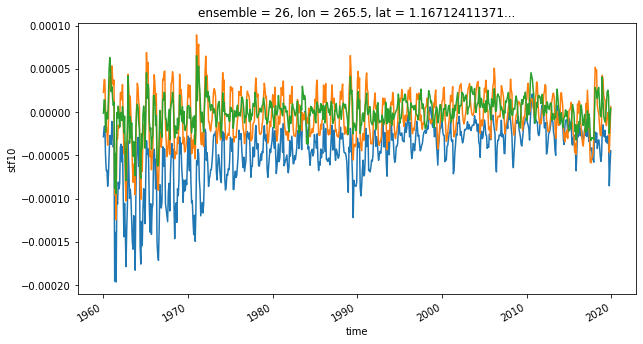

In [115]:
deseasonalised_co2.sel(lat=1,lon=265,method='nearest')#.plot()

<xarray.DataArray 'stf10' (time: 720, month: 12)>
array([[-1.2900509e-06, -5.6584213e-07, -1.0842559e-06, ...,
         4.4727385e-05,  3.9389197e-05,  2.0906871e-05],
       [ 1.3489700e-05,  1.4213909e-05,  1.3695495e-05, ...,
         5.9507136e-05,  5.4168951e-05,  3.5686622e-05],
       [ 1.3090032e-05,  1.3814240e-05,  1.3295827e-05, ...,
         5.9107468e-05,  5.3769283e-05,  3.5286954e-05],
       ...,
       [-7.0552276e-05, -6.9828071e-05, -7.0346483e-05, ...,
        -2.4534842e-05, -2.9873028e-05, -4.8355356e-05],
       [-4.7880727e-05, -4.7156522e-05, -4.7674934e-05, ...,
        -1.8632927e-06, -7.2014791e-06, -2.5683807e-05],
       [-1.7835840e-05, -1.7111632e-05, -1.7630045e-05, ...,
         2.8181596e-05,  2.2843409e-05,  4.3610826e-06]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
    ensemble  int32 26
    lon       float64 265.5
    lat       float64 1.167
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [96]:
#detrend(co2.interpolate_na(dim='time').sel(lat=1,lon=265,method='nearest'),'time').plot()#.sel(lat=1,lon=265,method='nearest')
#co2.sel(lat=1,lon=265,method='nearest').plot()

In [97]:
#detrended_co2=detrend(co2.stf10.interpolate_na(dim='time').astype(float),dim='time')

In [98]:
#detrended_pprod=detrend(eqpac.pprod_gross_2d.chunk({'time':-1}),dim='time')

In [ ]:
#detrended=detrend_dim(eqpac,dim='time')

In [44]:

result = detrended_co2.groupby("time.month") - detrended_co2.groupby("time.month").mean("time")

#da = da.assign_coords(month=da.time.dt.strftime("%Y-%m"))


In [24]:
detrended_co2.groupby('time.month').mean('time')

<xarray.DataArray 'stf10' (month: 12, lat: 98, lon: 170)>
array([[[ 4.53816256e-06,  2.74215690e-05,  2.64776827e-05, ...,
         -1.30862129e-04, -1.59604751e-04, -1.26331710e-04],
        [ 3.09339157e-06, -9.30738850e-07,  2.57153697e-05, ...,
         -1.45281389e-04, -1.41806304e-04, -9.65075888e-05],
        [ 3.29639647e-06, -3.92331259e-07,  2.49530476e-05, ...,
         -1.18527241e-04, -6.56580960e-05,  5.70363545e-06],
        ...,
        [ 4.64103796e-05, -4.46949780e-05,  4.18185373e-05, ...,
         -1.27338708e-05,  6.80647986e-07, -1.10018607e-06],
        [ 1.15120769e-04,  9.58082310e-05,  7.74983127e-05, ...,
          1.90592948e-06,  5.53221469e-07,  4.65041694e-06],
        [ 1.04220075e-04,  9.80467084e-05,  8.03732910e-05, ...,
         -2.31308763e-06,  4.25796401e-07,  4.63921060e-06]],

       [[-3.91318554e-06,  2.12618161e-05,  1.90086976e-05, ...,
         -1.24079932e-04, -1.51351240e-04, -1.17185285e-04],
        [-4.17939737e-06, -6.51356640e-06,  1.83564316e-05, ...,
         -1.41046170e-04, -1.37175375e-04, -8.97797800e-05],
        [-4.28289923e-06, -6.90903198e-06,  1.77041620e-05, ...,
         -1.12549518e-04, -5.89974043e-05,  6.05206196e-06],
...
         -3.20323707e-05,  7.79521633e-06, -1.45851218e-05],
        [ 7.32352564e-05,  6.13945158e-05,  4.93062034e-05, ...,
         -1.44410260e-05,  7.75880471e-06,  1.39626263e-05],
        [ 7.70703555e-05,  6.82149475e-05,  5.27490265e-05, ...,
          3.92338734e-06,  7.72239400e-06,  1.40886759e-05]],

       [[ 1.08566810e-05,  2.93219728e-05,  2.78392690e-05, ...,
         -1.54710084e-04, -1.80748117e-04, -1.41618628e-04],
        [ 8.03811145e-06,  6.66027518e-07,  2.71278968e-05, ...,
         -1.62441254e-04, -1.52301131e-04, -1.04178645e-04],
        [ 6.40113240e-06,  5.52062659e-07,  2.64165319e-05, ...,
         -1.28974541e-04, -7.05395432e-05,  4.06461413e-06],
        ...,
        [ 5.91196913e-05, -3.59028563e-05,  4.88749283e-05, ...,
         -2.40107274e-05,  5.11777534e-06, -8.18580247e-06],
        [ 1.24142040e-04,  1.08207569e-04,  8.66300616e-05, ...,
         -4.38507141e-06,  5.04590844e-06,  1.02248332e-05],
        [ 1.22463534e-04,  1.12625006e-04,  9.10875096e-05, ...,
          1.69453961e-06,  4.97404108e-06,  1.02903678e-05]]],
      dtype=float32)
Coordinates:
    ensemble  int32 26
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [36]:
seasonalised_co2=detrended_co2.groupby('time.month').mean(dim='time')
deseasonalised_co2=detrended_co2-seasonalised_co2

In [52]:
#plt.plot(detrended_co2.time,
detrended_co2.sel(lat=1,lon=265,method='nearest').load()#.values

ValueError: array must not contain infs or NaNs

In [45]:
seasonalised_co2.sel(lat=0,lon=270,method='nearest').plot()

ValueError: array must not contain infs or NaNs

In [ ]:
deseasonalised_co2.sel(lat=0,lon=270,method='nearest').drop('month').plot()

In [12]:
if regrid_fratios==True:
    fr=xr.open_dataset('../processed_data/fratios.nc')
    regridder = xe.Regridder(fr,bgcdatvs, 'bilinear',reuse_weights=False)
    fr_regrid=regridder(fr)
    fr_regrid.to_netcdf('../processed_data/fratios_rg.nc')
fr=xr.open_dataset('../processed_data/fratios_rg.nc')

In [13]:
client

<Client: 'tcp://10.0.128.135:36085' processes=16 threads=16, memory=119.20 GiB>

In [14]:
if process_interim==True:
    # BGC
    bgcdat=eqpac.sel(ensemble=ens,method='nearest').chunk(dict(time=-1))#,lat=lat,lon=lon
    bgcdatvs=bgcdat[['pco2','pprod_gross_2d','stf10','stf07','export_prod','dic','adic','pprod_gross','det','dpco2','caco3','surface_caco3','no3','fe','alk']].sel(st_ocean=slice(0,depth_integration)).mean(dim='st_ocean')

    ex=(bgcdat[['det']].sel(st_ocean=slice(0,depth_integration)).integrate(coord='st_ocean'))/10#10m/s)#.rename({'det':'nic_export'})
    bgcdatvs['nics_export']=ex.det

    dic_int=(bgcdat[['dic']].sel(st_ocean=slice(0,depth_integration)).integrate(coord='st_ocean'))#10m/s)#.rename({'det':'nic_export'})

    bgcdatvs['dic_integrated']=dic_int.dic

    bgcdatvs[['pprod_gross_2d','stf10','pprod_gross','stf07']]=bgcdatvs[['pprod_gross_2d','stf10','pprod_gross','stf07']]*60*60*24 # From seconds to day..

    bgcdatvs['trim_export']=bgcdatvs.pprod_gross*fr.trim
    bgcdatvs['laws_export']=bgcdatvs.pprod_gross*fr.laws2011a.mean(dim='time')
    bgcdatvs['trim_export_2d']=bgcdatvs.pprod_gross_2d*fr.trim
    bgcdatvs['laws_export_2d']=bgcdatvs.pprod_gross_2d*fr.laws2011a.mean(dim='time')


    bgcdatvs.to_netcdf('../processed_data/model_proc_temp/epac_bgc.nc')

In [15]:
if process_interim==True:
    # PHYSICS
    physdat=phys_eqpac.sel(ensemble=ens,method='nearest').chunk(dict(time=-1))
    physdatvs=physdat[['temp','salt','sst']].sel(st_ocean=slice(0,depth_integration)).mean(dim='st_ocean')

    # Calculate solubility from t and s....
    physdatvs=physdatvs.chunk(dict(time=-1))
    physdatvs['solubility']=xr.apply_ufunc(solubility,
                                            physdatvs['temp']+273.15,
                                            physdatvs['salt'],
                                            dask='parallelized',
                                            vectorize=True,
                                            output_dtypes=['float64'])
    physdatvs.to_netcdf('../processed_data/model_proc_temp/epac_phys.nc')

In [16]:
bgcdatvs=xr.open_dataset('../processed_data/model_proc_temp/epac_bgc.nc')
physdatvs=xr.open_dataset('../processed_data/model_proc_temp/epac_phys.nc')

In [17]:
# Combine BGC and physics DFs.

physdatvs['time']=bgcdatvs['time']

bgcdatvs['temp']=physdatvs['temp']
bgcdatvs['sst']=physdatvs['sst']
bgcdatvs['salt']=physdatvs['salt']
bgcdatvs['solubility']=physdatvs['solubility']

# Calculate mols of dpco2 and pco2. 
# sol in mol/atm/l * 1000=mol/atm/m3
# pCO2 in uatm / 1000000=atm
# dpco2mol is molC/m3, *1000 gives mmolC/m3
bgcdatvs['dpco2mmol']=((bgcdatvs['dpco2']/1000000)*(bgcdatvs['solubility']*1000))*1000
bgcdatvs['pco2mmol']=((bgcdatvs['pco2']/1000000)*(bgcdatvs['solubility']*1000))*1000

# Calc Export
bgcdatvs['trim_export_2d']=bgcdatvs.pprod_gross_2d*fr.trim
bgcdatvs['laws_export_2d']=bgcdatvs.pprod_gross_2d*fr.laws2011a.mean(dim='time')
bgcdatvs.to_netcdf('../processed_data/epac_sensitivity_variables.nc')

In [18]:
# Check plot looks ok
bgcdatvs#['dpco2mmol'].mean(dim='time').plot()

<xarray.Dataset>
Dimensions:         (time: 720, lat: 98, lon: 170)
Coordinates:
  * time            (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
    ensemble        int32 ...
  * lon             (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat             (lat) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
Data variables: (12/27)
    pco2            (time, lat, lon) float32 341.6 nan nan nan ... nan nan nan
    pprod_gross_2d  (time, lat, lon) float32 ...
    stf10           (time, lat, lon) float32 ...
    stf07           (time, lat, lon) float32 ...
    export_prod     (time, lat, lon) float32 ...
    dic             (time, lat, lon) float32 ...
    ...              ...
    temp            (time, lat, lon) float32 ...
    sst             (time, lat, lon) float32 ...
    salt            (time, lat, lon) float32 ...
    solubility      (time, lat, lon) float64 0.02652 nan nan nan ... nan nan nan
    dpco2mmol       (time, lat, lon) float64 0.6773 nan nan nan ... nan nan nan
    pco2mmol        (time, lat, lon) float64 9.06 nan nan nan ... nan nan nan

In [19]:
client

<Client: 'tcp://10.0.128.135:36085' processes=16 threads=16, memory=119.20 GiB>

In [20]:
# Calculate the trends
bgcdatvs=xr.open_dataset('../processed_data/epac_sensitivity_variables.nc')
if process_trends==True:
    pco2_tr=lin_wrapper(bgcdatvs,startyear=startyear,endyear=endyear)
    pco2_tr.sel(stats=0).to_netcdf(f'../processed_data/epac_sensitivity_variables_{startyear}_{endyear}.nc')
pco2_tr=xr.open_dataset(f'../processed_data/epac_sensitivity_variables_{startyear}_{endyear}.nc')

In [21]:
# Look at a single pixel region
varz=pco2_tr.sel(lat=lat,lon=lon,method='nearest')#.sel(stats=0)
varz.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:         ()
Coordinates:
    ensemble        int32 ...
    lon             float64 270.5
    lat             float64 0.1662
Data variables: (12/27)
    pco2            float64 ...
    pprod_gross_2d  float64 ...
    stf10           float64 ...
    stf07           float64 ...
    export_prod     float64 ...
    dic             float64 ...
    ...              ...
    temp            float64 ...
    sst             float64 ...
    salt            float64 ...
    solubility      float64 ...
    dpco2mmol       float64 ...
    pco2mmol        float64 ...>

In [22]:
# Simple outputs to look at. Things processed now what?

print(f'Location {lat}N {lon} integrated for {depth_integration}m depth integration 2000-2017 (because aCO2)\n') 
print(f'Change in Mean DIC:\t\t {np.round(varz.dic.values,3)} mmolC/m3/yr ')
print(f'Change in depth integrated DIC:\t {np.round(varz.dic_integrated.values,3)} mmolC/m3/yr ')
print(f'Change in Pprod:\t\t {np.round(varz.pprod_gross_2d.values*365*6.625,3)} mmolC/m3/yr/yr ')
print(f'Change in Simple Trim Export:\t {np.round(varz.trim_export_2d.values*365*6.625,3)} mmolC/m3/yr/yr ')
print(f'Change in Det*10m/s:\t\t {np.round(varz.nics_export.values*365*6.625,3)} mmolC/m3/yr/yr ')
print(f'Change in Flux:\t\t\t {np.round(varz.stf10.values*365,3)} mmolC/m3/yr/yr ')
print(f'Change in pCO2:\t\t\t {np.round(varz.dpco2mmol.values*365,3)} mmolC/m3/yr ')
print(f'Change in dpCO2:\t\t {np.round(varz.pco2mmol.values*365,3)} mmolC/m3/yr ')
print(f'Change in temp:\t\t\t {np.round(varz.temp.values,3)} degC/yr ')
print(f'Change in salt:\t\t\t {np.round(varz.salt.values,3)} psu/yr ')

#print(f'Change in NatFlux: {np.round(varz.stf07.values,3)} mmolC/m3/day/yr ')

Location 0N 270 integrated for 100m depth integration 2000-2017 (because aCO2)

Change in Mean DIC:		 1.207 mmolC/m3/yr 
Change in depth integrated DIC:	 111.858 mmolC/m3/yr 
Change in Pprod:		 119.317 mmolC/m3/yr/yr 
Change in Simple Trim Export:	 21.821 mmolC/m3/yr/yr 
Change in Det*10m/s:		 12.548 mmolC/m3/yr/yr 
Change in Flux:			 25.327 mmolC/m3/yr/yr 
Change in pCO2:			 -38.225 mmolC/m3/yr 
Change in dpCO2:		 -6.349 mmolC/m3/yr 
Change in temp:			 -0.042 degC/yr 
Change in salt:			 0.002 psu/yr 


In [23]:
# Ok lets load the dataset and try plotting some simple trends. 
pco2_tr=xr.open_dataset(f'../processed_data/epac_sensitivity_variables_{startyear}_{endyear}.nc')

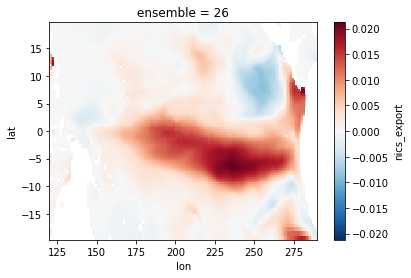

In [24]:
pco2_tr.nics_export.plot()

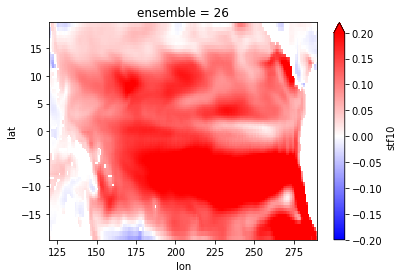

In [25]:
pco2_tr.stf10.plot(vmin=-0.2,vmax=0.2,cmap='bwr')

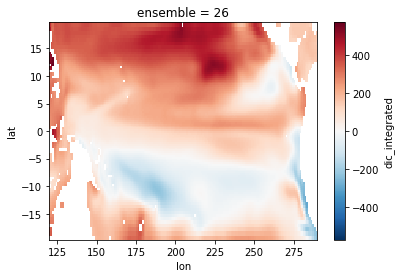

In [26]:
pco2_tr.dic_integrated.plot()#vmin=-0.2,vmax=0.2,cmap='bwr')

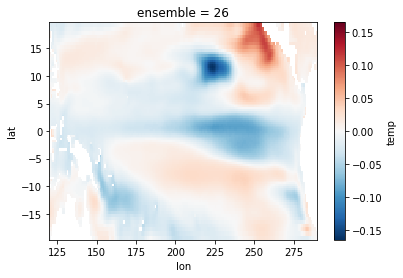

In [27]:
pco2_tr.temp.plot()

In [28]:
start_vars=bgcdatvs.sel(lat=lat,lon=lon,time=f'{startyear}-01-01',method='nearest')
end_vars=bgcdatvs.sel(lat=lat,lon=lon,time=f'{endyear}-01-01',method='nearest')

In [29]:
start_vars

<xarray.Dataset>
Dimensions:         ()
Coordinates:
    time            datetime64[ns] 2000-01-01
    ensemble        int32 ...
    lon             float64 270.5
    lat             float64 0.1662
Data variables: (12/27)
    pco2            float32 ...
    pprod_gross_2d  float32 ...
    stf10           float32 ...
    stf07           float32 ...
    export_prod     float32 ...
    dic             float32 ...
    ...              ...
    temp            float32 ...
    sst             float32 ...
    salt            float32 ...
    solubility      float64 ...
    dpco2mmol       float64 ...
    pco2mmol        float64 ...

In [30]:
# First test with co2sys. Maybe use Alkalinity instead so we can see the sensitivity of pCO2. 
# Types
# Alk; 1, DIC; 2, pH; 3, pCO2; 4, Fugacity; 5,aqueousCO2;8, dry mol fraction co2; 9, Carbonate;6, Bicarbonate;7 
#@ Mostly in umol kg-1 or uatm
input_dat=end_vars#start_vars
system=pyco2.sys(par1=input_dat.dic,
          par2=input_dat.alk,#pco2,
          par1_type=2, #DIC
          par2_type=1,#4, #pCO2
          salinity=input_dat.salt,
          temperature=input_dat.temp)
print(system.get('pCO2'))

371.97635942948006


In [31]:
def co2sys_sensitivity(dic,alk,salt,temp,caco3):
    system=pyco2.sys(par1=dic,
          par2=alk,#pco2,
          par1_type=2, #DIC
          par2_type=1, #4, #pCO2
          salinity=salt,
          temperature=temp,
          total_calcium=caco3)
    return system.get('pCO2')

In [32]:
# Check Change at single pixel 
diff=end_vars-start_vars

a1=co2sys_sensitivity(start_vars.dic,start_vars.alk,start_vars.salt,start_vars.temp,start_vars.caco3)
a2=co2sys_sensitivity(end_vars.dic,start_vars.alk,start_vars.salt,start_vars.temp,start_vars.caco3)
a3=co2sys_sensitivity(start_vars.dic,end_vars.alk,start_vars.salt,start_vars.temp,start_vars.caco3)
a4=co2sys_sensitivity(start_vars.dic,start_vars.alk,end_vars.salt,start_vars.temp,start_vars.caco3)
a5=co2sys_sensitivity(start_vars.dic,start_vars.alk,start_vars.salt,end_vars.temp,start_vars.caco3)
a6=co2sys_sensitivity(start_vars.dic,start_vars.alk,start_vars.salt,start_vars.temp,end_vars.caco3*50)
print(f'Baseline: {a1} uatm with no difference')
print(f'end DIC: {a2} uatm with DIC difference {diff.dic.values}')
print(f'end Alk: {a3} uatm with Alk difference {diff.alk.values}')
print(f'end Salt: {a4} uatm with Salt difference {diff.salt.values}')
print(f'end Temp: {a5} uatm with Temp difference {diff.temp.values}')
print(f'end Calcium: {a6} uatm with Calcium difference {diff.caco3.values}')

# Convert new production into deltaDIC 

Baseline: 349.6498536403065 uatm with no difference
end DIC: 393.07622207539504 uatm with DIC difference 22.9384765625
end Alk: 333.1158852334191 uatm with Alk difference 11.771484375
end Salt: 349.80473712982115 uatm with Salt difference 0.01660919189453125
end Temp: 347.98389706160145 uatm with Temp difference -0.11544418334960938
end Calcium: 349.6498536403065 uatm with Calcium difference -0.02265229821205139


In [33]:
end_vars.caco3

<xarray.DataArray 'caco3' ()>
array(0.159266, dtype=float32)
Coordinates:
    time      datetime64[ns] 2017-01-01
    ensemble  int32 26
    lon       float64 270.5
    lat       float64 0.1662

In [34]:
pyco2.sys
# CO2 sys PAR_1 and PAR_2 Types:

#Total alkalinity (type 1) in μmol·kg−1.
#Dissolved inorganic carbon (type 2) in μmol·kg−1.
#pH (type 3) on the Total, Seawater, Free or NBS scale1. Which scale is given by the argument opt_pH_scale.
#Any one of:
#Partial pressure of CO2 (type 4) in μatm,
#Fugacity of CO2 (type 5) in μatm,
#Aqueous CO2 (type 8) in μmol·kg−1, or
#Dry mole fraction of CO2 (type 9) in ppm.
#Carbonate ion (type 6) in μmol·kg−1.
#Bicarbonate ion (type 7) in μmol·kg−1.

<function PyCO2SYS.engine.nd.CO2SYS(par1=None, par2=None, par1_type=None, par2_type=None, salinity=35, temperature=25, pressure=0, temperature_out=None, pressure_out=None, total_ammonia=0, total_phosphate=0, total_silicate=0, total_sulfide=0, total_borate=None, total_calcium=None, total_fluoride=None, total_sulfate=None, opt_gas_constant=3, opt_k_bisulfate=1, opt_k_carbonic=16, opt_k_fluoride=1, opt_pH_scale=1, opt_total_borate=1, buffers_mode='auto', k_ammonia=None, k_ammonia_out=None, k_borate=None, k_borate_out=None, k_bisulfate=None, k_bisulfate_out=None, k_CO2=None, k_CO2_out=None, k_carbonic_1=None, k_carbonic_1_out=None, k_carbonic_2=None, k_carbonic_2_out=None, k_fluoride=None, k_fluoride_out=None, k_phosphoric_1=None, k_phosphoric_1_out=None, k_phosphoric_2=None, k_phosphoric_2_out=None, k_phosphoric_3=None, k_phosphoric_3_out=None, k_silicate=None, k_silicate_out=None, k_sulfide=None, k_sulfide_out=None, k_water=None, k_water_out=None, k_calcite=None, k_calcite_out=None, k_ar

In [35]:
diff.dpco2mmol.values # Total difference in pCO2 in mmols over the period.   mmolC/m3/

array(0.59465472)

In [36]:
diff.dpco2mmol.values # Total difference in pCO2 in mmols over the period.   mmolC/m3

array(0.59465472)

In [37]:
diff

<xarray.Dataset>
Dimensions:         ()
Coordinates:
    ensemble        int32 26
    lon             float64 270.5
    lat             float64 0.1662
Data variables: (12/27)
    pco2            float32 51.87
    pprod_gross_2d  float32 0.162
    stf10           float32 -1.394
    stf07           float32 -1.375
    export_prod     float32 nan
    dic             float32 22.94
    ...              ...
    temp            float32 -0.1154
    sst             float32 0.1116
    salt            float32 0.01661
    solubility      float64 0.0001179
    dpco2mmol       float64 0.5947
    pco2mmol        float64 1.903

In [38]:
loc=bgcdatvs.sel(lat=lat,lon=lon,method='nearest')#.plot()

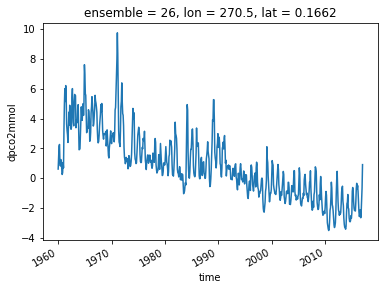

In [39]:
loc.dpco2mmol.plot()

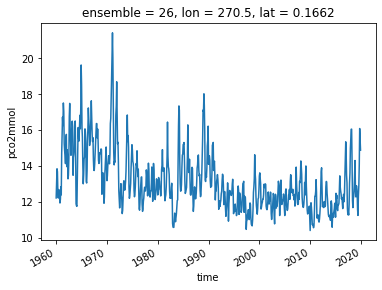

In [40]:
loc.pco2mmol.plot()

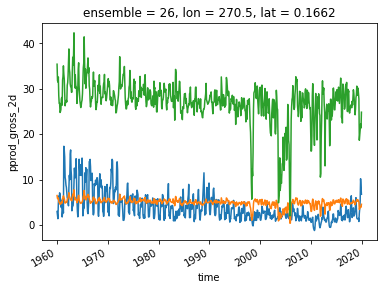

In [41]:
(loc.stf10*-1).plot()
#loc.stf07.plot()
(loc.trim_export_2d*6.625).plot()
(loc.pprod_gross_2d*6.625).plot()

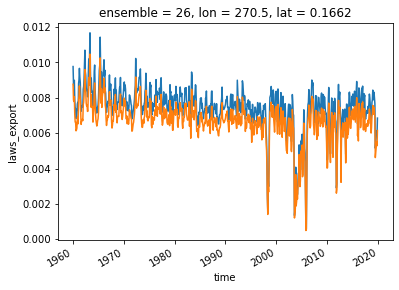

In [42]:
loc.trim_export.plot()
loc.laws_export.plot()

In [43]:
loc

<xarray.Dataset>
Dimensions:         (time: 720)
Coordinates:
  * time            (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
    ensemble        int32 26
    lon             float64 270.5
    lat             float64 0.1662
Data variables: (12/27)
    pco2            (time) float32 ...
    pprod_gross_2d  (time) float32 5.343 4.801 4.749 4.919 ... 3.353 3.223 3.748
    stf10           (time) float32 -2.958 -2.018 -1.371 ... -10.17 -8.268 -6.748
    stf07           (time) float32 ...
    export_prod     (time) float32 ...
    dic             (time) float32 ...
    ...              ...
    temp            (time) float32 ...
    sst             (time) float32 ...
    salt            (time) float32 ...
    solubility      (time) float64 ...
    dpco2mmol       (time) float64 ...
    pco2mmol        (time) float64 ...

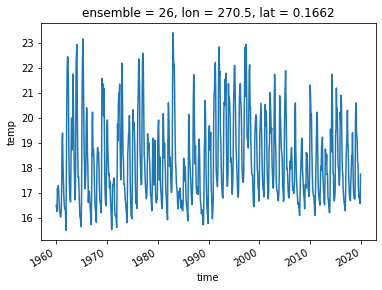

In [44]:
loc.temp.plot()

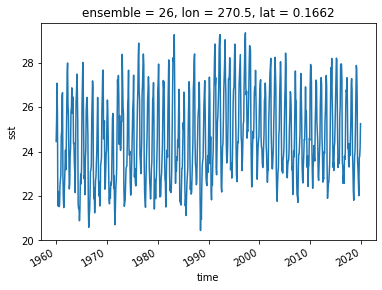

In [45]:
loc.sst.plot()

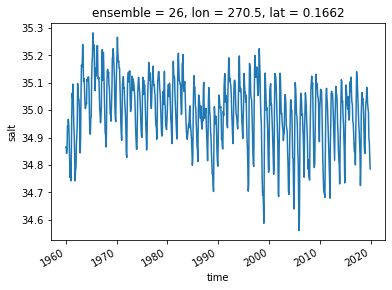

In [46]:
loc.salt.plot()

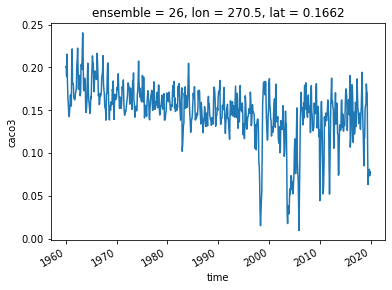

In [48]:
loc.caco3.plot()

In [80]:
d.columns

Index(['pco2', 'pprod_gross_2d', 'stf10', 'stf07', 'export_prod', 'dic',
       'adic', 'pprod_gross', 'det', 'dpco2', 'caco3', 'surface_caco3', 'no3',
       'fe', 'alk', 'ensemble', 'lon', 'lat', 'nics_export', 'dic_integrated',
       'trim_export', 'laws_export', 'trim_export_2d', 'laws_export_2d',
       'temp', 'sst', 'salt', 'solubility', 'dpco2mmol', 'pco2mmol'],
      dtype='object')

Text(0.5, 1.0, 'Correlation between useful vars at 0N 110W')

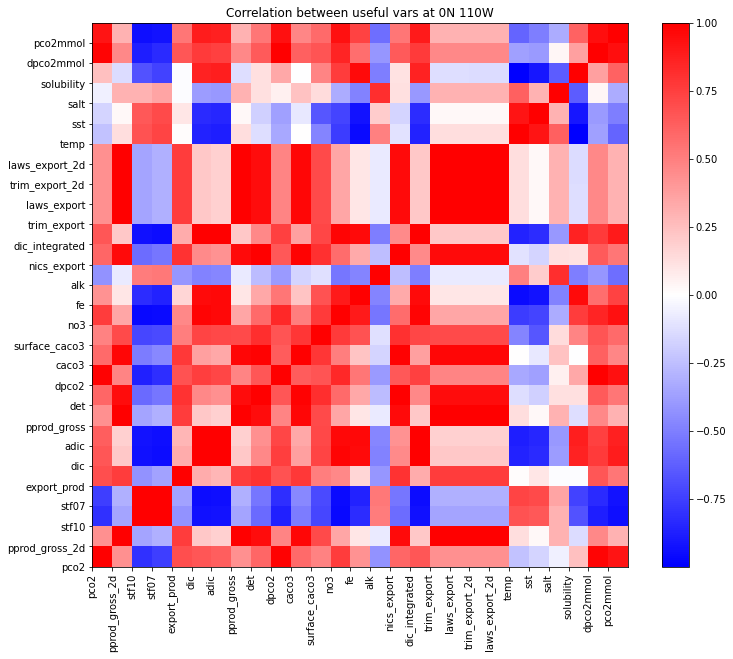

In [107]:
plt.figure(figsize=(12,10))
d=loc.to_pandas()#drop(['ensemble','lat','lon'])
d=d.corr().drop(['ensemble','lat','lon'],axis=0).drop(['ensemble','lat','lon'],axis=1)
plt.pcolormesh(d.corr(),cmap='bwr')
_=plt.xticks(np.arange(0,len(d.columns)),d.columns,rotation=90)#.plot.density()#(kind='pcolor')
_=plt.yticks(np.arange(0,len(d.columns)),d.columns)
plt.colorbar()#ap='bwr')
plt.title('Correlation between useful vars at 0N 110W')

In [101]:
#Ok so negative variables are 
# Possitive correlation variables are
# pco2
# Primary production2d, 
# export prod
# DIC
# adic
# primary prod gross
# Detrutyse
# dpco2
# pco2 
# caco3
# no3
# fe
# alk
# nic exporet
# ddic integtrated
# erxports



# CO2 flux
# Nat flux
# Alkaliniyty
# Temp
# SST
# Salt

,pco2,pprod_gross_2d,stf10,stf07,export_prod,dic,adic,pprod_gross,det,dpco2,...,trim_export,laws_export,trim_export_2d,laws_export_2d,temp,sst,salt,solubility,dpco2mmol,pco2mmol
pco2,1.000000,0.363122,-0.557767,-0.447175,0.808296,0.518069,0.478017,0.363240,0.480292,0.943856,...,0.363240,0.363240,0.363122,0.363122,0.053216,0.192468,0.213333,-0.050411,0.943134,0.920391
pprod_gross_2d,0.363122,1.000000,-0.229571,-0.158229,0.927775,0.265395,0.234505,0.999999,0.889201,0.437584,...,0.999999,0.999999,1.000000,1.000000,0.152299,0.078219,0.380141,-0.158190,0.424930,0.274176
stf10,-0.557767,-0.229571,1.000000,0.973798,-0.710650,-0.763740,-0.729163,-0.229767,-0.325076,-0.650584,...,-0.229767,-0.229767,-0.229571,-0.229571,0.356409,0.489736,-0.063745,-0.361869,-0.670712,-0.674968
stf07,-0.447175,-0.158229,0.973798,1.000000,-0.666183,-0.740359,-0.720124,-0.158427,-0.241899,-0.523780,...,-0.158427,-0.158427,-0.158229,-0.158229,0.433591,0.587383,0.014891,-0.438827,-0.545675,-0.601333
export_prod,0.808296,0.927775,-0.710650,-0.666183,1.000000,0.206639,0.156733,0.927828,0.957133,NaN,...,0.927828,0.927828,0.927775,0.927775,0.225100,0.759876,-0.816932,-0.194732,NaN,0.756590
dic,0.518069,0.265395,-0.763740,-0.740359,0.206639,1.000000,0.983790,0.265675,0.426959,0.603598,...,0.265675,0.265675,0.265395,0.265395,-0.665596,-0.528991,-0.188482,0.672223,0.624201,0.749899
adic,0.478017,0.234505,-0.729163,-0.720124,0.156733,0.983790,1.000000,0.234680,0.390899,0.533408,...,0.234680,0.234680,0.234505,0.234505,-0.681886,-0.528448,-0.207676,0.687517,0.556036,0.718940
pprod_gross,0.363240,0.999999,-0.229767,-0.158427,0.927828,0.265675,0.234680,1.000000,0.889241,0.437814,...,1.000000,1.000000,0.999999,0.999999,0.152032,0.077927,0.380170,-0.157920,0.425165,0.274391
det,0.480292,0.889201,-0.325076,-0.241899,0.957133,0.426959,0.390899,0.889241,1.000000,0.549415,...,0.889241,0.889241,0.889201,0.889201,-0.061166,-0.023511,0.248176,0.052971,0.543950,0.465629
dpco2,0.943856,0.437584,-0.650584,-0.523780,NaN,0.603598,0.533408,0.437814,0.549415,1.000000,...,0.437814,0.437814,0.437584,0.437584,0.025618,0.059094,0.283735,-0.022076,0.998570,0.878574


In [54]:
lobgcdatvs#.crosscorr()

<xarray.Dataset>
Dimensions:         (time: 720, lat: 98, lon: 170)
Coordinates:
  * time            (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
    ensemble        int32 26
  * lon             (lon) float64 120.5 121.5 122.5 123.5 ... 287.5 288.5 289.5
  * lat             (lat) float64 -19.36 -18.59 -17.85 ... 17.85 18.59 19.36
Data variables: (12/27)
    pco2            (time, lat, lon) float32 ...
    pprod_gross_2d  (time, lat, lon) float32 ...
    stf10           (time, lat, lon) float32 ...
    stf07           (time, lat, lon) float32 ...
    export_prod     (time, lat, lon) float32 ...
    dic             (time, lat, lon) float32 ...
    ...              ...
    temp            (time, lat, lon) float32 ...
    sst             (time, lat, lon) float32 ...
    salt            (time, lat, lon) float32 ...
    solubility      (time, lat, lon) float64 ...
    dpco2mmol       (time, lat, lon) float64 ...
    pco2mmol        (time, lat, lon) float64 ...

In [53]:
xr.corr(bgcdatvs)

TypeError: corr() missing 1 required positional argument: 'da_b'

In [ ]:
def co2sys_sensitivity(dic,alk,salt,temp,caco3):
    system=pyco2.sys(par1=dic,
          par2=alk,#pco2,
          par1_type=2, #DIC
          par2_type=1, #4, #pCO2
          salinity=salt,
          temperature=temp,
          total_calcium=caco3)
    return system.get('pCO2')


a3=co2sys_sensitivity(start_vars.dic,end_vars.alk,start_vars.salt,start_vars.temp,start_vars.caco3)

array(2361.2927, dtype=float32)

In [129]:
dic=loc.dic.mean().values
salt=loc.salt.mean().values
temp=loc.temp.mean().values
alk=loc.alk.mean().values
caco3=loc.caco3.mean().values

ans=pyco2.sys(par1=dic,
          par2=alk,#pco2,
          par1_type=2, #DIC
          par2_type=1, #4, #pCO2
          salinity=salt,
          temperature=temp,
          total_calcium=caco3)#,
          #total_calcium=caco3)
    
print(ans.get('pCO2'))

378.02392345823677


In [124]:
# Baseline
dic=loc.dic.mean().values
salt=loc.salt.mean().values
temp=loc.temp.mean().values
alk=loc.alk.mean().values
caco3=loc.caco3.mean().values

ans=pyco2.sys(par1=dic,
          par2=alk,#pco2,
          par1_type=2, #DIC
          par2_type=1, #4, #pCO2
          salinity=salt,
          temperature=temp,
          total_calcium=caco3)#,
          #total_calcium=caco3)
    
print(ans.get('pCO2'))

array(2361.2927, dtype=float32)

In [144]:
# What happens if we change each of these values by 50%

perc=1.1#.20 # But in decimal
varz=[dic,alk,salt,temp,caco3]
for i,v in enumerate(varz):
    varz[i]=varz[i]*perc
    
    ans=pyco2.sys(par1=varz[0],
          par2=varz[1],#pco2,
          par1_type=2, #DIC
          par2_type=1, #4, #pCO2
          salinity=varz[2],
          temperature=varz[3],
          total_calcium=varz[4])
    print(ans.get('pCO2'))

1379.2322380088879
401.9635910571968
439.8473564422278
474.1647994088452
474.1647994088452


In [131]:
150*1.5

225.0

In [135]:
varz

[3145.389404296875,
 3541.9390869140625,
 52.491085052490234,
 27.419068336486816,
 0.22297319769859314]

In [140]:
varz[0]#*1.5

array(2096.9263, dtype=float32)